In [3]:
##### Initial Notebook Setup ####

#Setup so that all output in a cell are printed and not just the last line
    #Source: http://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Essential things for SymPy
from sympy import *
init_printing(use_unicode=True)

# Kinematics using SymPy
In this notebook, we will discuss various ways to do Kinematics using SymPy.

From what I've discovered so far, it seems like there are multiple ways to do Kinematics:

* Vectors Module
* Physics Module

They have many common functionalities. E.g. Physics module doesn't seem to leverage the classes from Vector module, and defines its own classes and methods for Vectors and Coordinate Systems.

## Difference b/e Coordinate System Definition in Vector and Physics Modules
In Physics module, the primitive concept is of Reference Frame, which is defined without any origin. What matters is the rotation w.r.t. another reference frame. This is a good way of defining, because in Mechanics this is the way a reference frame is defined. Origin doesn't make any sense for a reference frame. It comes into picture when you're talking about Coordinate Axes.

Coordinate Axes are the primitive objects in Vector module. They come both with an orientation and a translational part (i.e. origin is defined).

## Refs:
* https://stackoverflow.com/questions/9492944/sympy-arbitrary-number-of-symbols
* https://www.researchgate.net/publication/267490975_Constrained_Multibody_Dynamics_With_Python_From_Symbolic_Equation_Generation_to_Publication

# 1. Exploring Physics Module
In this section, we will explore the Physics module.

Physics module defines its own Vector class **physics.vector**. This class is used by other Physics classes, e.g. by Classical Mechanics, Quantum Mechanics etc.

In [4]:
from sympy import *
x, t, z, nu = symbols('x t z nu')
init_printing(use_unicode=True)
diff(sin(x)*exp(x), x)

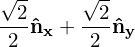

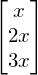

In [3]:
from sympy.physics.vector import *
N = ReferenceFrame('N')
N.x
(N.x + N.y).normalize()
(x * N.x + 2 * x * N.y + 3 * x * N.z).to_matrix(N)

## 1.1 Relating 2 Frames
In this section, we now introduce a new frame and relate it to the previous one. This allows us to explore DCMs, Euler Angles, Quaternions and such.

In [4]:
A = ReferenceFrame('A')
A.orient(N, 'Axis', [x, N.y])

# 2. Vector Module

http://docs.sympy.org/latest/modules/vector/basics.html

In [7]:
from sympy.vector import CoordSys3D
N = CoordSys3D('N')
v1 = N.i + N.k
type(v1) #This is essentially a vector (it will show this to be a sub-class by the name VectorAdd)
list(v1.components.values())


#Introducing Points
type(N.origin)
P = N.origin.locate_new('P', 2*N.i)
Q = P.locate_new('Q', 3*N.j)
Q.position_wrt(N.origin)
Q.position_wrt(N)
Q.express_coordinates(N) #Express coords in the reference frame N

sympy.vector.vector.VectorAdd

sympy.vector.point.Point

In [8]:
#Some operations that we can do with Vectors
from sympy.abc import a,b,c, theta #Helps to quickly define a lot of symbols
v = (a*b + a*c + b**2 + b*c)*N.i + b*N.j
diff(v,b)

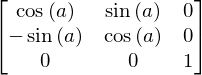

In [9]:
#Defining (Locating and Orienting) new coordinate systems w.r.t. a given one
A = N.orient_new_axis('C', a, N.k, location=2*N.j) #Rotated by 'a' radians in N.k direction
A.rotation_matrix(N)

#Using orienters to define orientation
#BodyOrienter ==> Body Fixed Angles (Euler and such)
#SpaceOrienter ==> Ground Fixed Angles (won't be using this)
from sympy.vector import AxisOrienter, BodyOrienter, SpaceOrienter
axis_orienter = AxisOrienter(theta, A.k)
body_orienter = BodyOrienter(a, b, c, 'XYZ')
B = A.orient_new('B', axis_orienter)
C = B.orient_new('C', body_orienter)

#C.rotation_matrix(B)
#C.rotation_matrix(N)

# Bennett Mechanism Analysis

Now, we proceed towards doing the forward kinematics of the Bennett Mechanism symbolically using our custom SymPy Quaternion module.

In [13]:
from sympy.abc import alpha, beta, a, b, c, d
from sympy import *
from sympy_quaternions import *
from sympy.vector import *

#Bennet Setup
n = 4 #Number of links/joints in the mechanism
a = 1
alpha = pi/8
#Inputting DH-parameters for this mechanism in the format (alpha, a, d). Theta is the variable and hence is not provided
dhp = ((alpha, a, 0), (-alpha, a, 0), (alpha, a, 0), (-alpha, a, 0))
ALPHA = (alpha, -alpha, alpha, -alpha)
A = (a, a, a, a)
THETA = list(symbols('theta0:' + str(n)))
X, Y, Z = symbols('X0:' + str(n)), symbols('Y0:' + str(n)), symbols('Z0:' + str(n))

#Initial Condition for FWD Kinematics
THETA[0] = pi/2

#Begin 3D Transformation Operations
#from sympy.vector import CoordSys3D, QuaternionOrienter
#def q_orienter(angle=alpha, axis=(1,0,0)):
#    q0, q1, q2, q3 = quat_around_axis(angle, axis)
#    return QuaternionOrienter(q0, q1, q2, q3)
#N1 = CoordSys3D('N1')
#D = N1.orient_new('D', (q_orienter(THETA[0], axis=(1,0,0)),\
#                        q_orienter(THETA[1], axis=(0,1,0)),\
#                        q_orienter(THETA[2], axis=(0,0,1)), ))
#simplify(D.rotation_matrix(N1))

#Quaternion Composition for Rotation Loop-closure Equations
angle = pi/2
Q = [] #list of quaternions
for i in range(n):
    Q.append(quat_around_axis(ALPHA[i], (1, 0, 0)))
    Q.append(quat_around_axis(THETA[i], (0, 0, 1)))
    
q = qmult_many(Q) #Body-fixed rotation composition
#simplify(q)
#q = simplify(q)
equations = qoperate(q, (1,0,0,0), "-")

#Axes Transformation for Vector Loop-closure Equations
O = CoordSys3D('O')
B = O.orient_new_axis('B', 0, O.k) #Initiate body-frame 'B' by replicating space-frame 'O'
for i in range(n):
    body_orienter = BodyOrienter(ALPHA[i], THETA[i], 0, 'XZX')
    #Following line can be used to test. It should come back to O.origin if given 4 consecutive pi/2 rotations
    #body_orienter = BodyOrienter(0, pi/2, 0, 'XZX')
    B = B.orient_new('B', (body_orienter, ), location=A[i]*B.i)

#express(B.position_wrt(O), O)
v = B.origin.express_coordinates(O)
equations = equations + v #Final set equations is Ready

In [ ]:
#THETA[1:]
solve(equations, THETA[1:])

In [ ]:
from sympy.abc import x,y,z
solve((x+y-1, x-2), (x,y))

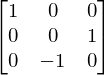

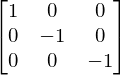

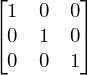

In [37]:
symbols('X_a^1')
N = CoordSys3D('N')
M = N.orient_new_axis('M', pi/2, N.i)
M.rotation_matrix(N)
body_orienter = BodyOrienter(pi/2, 0, 0, 'XZX')
M = M.orient_new('M', (body_orienter, ))
M.rotation_matrix(N)
G = N.orient_new_axis('G', 0, N.k)
G.rotation_matrix(N)

# Quaternions and such

Transformations for Euler-Anglers, Rotation Matrices, Quaternions, Angle-Axis etc.

### Refs:
* https://github.com/matthew-brett/transforms3d/tree/master/transforms3d/derivations

In [13]:
from sympy import *
from sympy_quaternions import *
from sympy.abc import alpha, beta, a, b, c, d

q1 = quat_around_axis(beta, (1,0,0))
q2 = quat_around_axis(beta, (0,1,0))
a = quat2mat(q1)
b = quat2axis(q1)

angle = pi/2
q3 = quat_around_axis(angle, (1, 0, 0))
q4 = quat_around_axis(angle, (0, 1, 0))
q5 = quat_around_axis(angle, (0, 0, 1))
q6 = quat_around_axis(angle, (0, -1, 0))
Q = (q6, q5, q4, q3) #Space-fixed rotation
q = qmult_many(Q)

q
#Now, we solve the equation q = (1,0,0,0), i.e. net rotation is zero
equations = qoperate(q, (1,0,0,0), "-")
#solve(equations, (beta))

q3 = quat_around_axis(angle, (1, 0, 0))
q4 = quat_around_axis(angle, (0, 1, 0))
q5 = quat_around_axis(angle, (-1, 0, 0))
q6 = quat_around_axis(angle, (0, 0, -1))
Q = (q3, q4, q5, q6) #Body-fixed rotation
q = qmult_many(Q)
q


# Exploring Solvers

Especially the under-determined equations solvers.

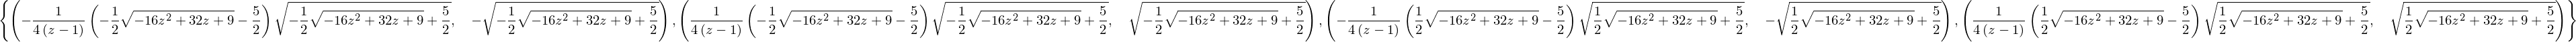

In [12]:
from sympy.core.symbol import symbols
from sympy.solvers.solveset import nonlinsolve
x, y, z = symbols('x, y, z', real=True)
nonlinsolve([x*y + z - 1, 4*x**2 + y**2 - 5], [x, y])
